In [117]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from catboost import Pool, cv
from sklearn.model_selection import GridSearchCV

from ast import literal_eval
from tqdm.notebook import tqdm

In [118]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [119]:
tqdm.pandas()

In [120]:
def clear_floor(row):
    try:
        return float(row)
    except:
        return 0

In [121]:
target = 'per_square_meter_price'

In [122]:
df_train = pd.read_csv('../real-estate/data/df_train_v5.csv', compression='zip')

/Users/alitvintsev/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [123]:
df_train = df_train.drop(columns='Unnamed: 0')

In [124]:
df_train['floor_cor'] = df_train['floor'].fillna(0).apply(clear_floor).astype(int)

df_train['street'] = df_train['street'].fillna('Unknown')
df_train['region'] = df_train['region'].fillna('Unknown')
df_train['city'] = df_train['city'].fillna('Unknown')
df_train['realty_type'] = df_train['realty_type'].fillna('Unknown')
df_train['osm_city_nearest_name'] = df_train['osm_city_nearest_name'].fillna('Unknown')

In [125]:
df_train[['floor', 'floor_cor']].tail(n=30)

,floor,floor_cor
279762,NaN,0
279763,1.0,1
279764,NaN,0
279765,1,1
279766,7,7
279767,1.0,1
279768,7,7
279769,7,7
279770,6,6
279771,6,6


In [126]:
df_train['floor'].value_counts()[:20]

1.0     70393
2.0      7750
-1.0     7738
3.0      3516
1.0      2478
4.0      2194
5.0      1387
0.0       893
-2.0      762
6.0       673
7.0       671
1         442
2.0       352
8.0       340
-1.0      327
9.0       302
10.0      238
11.0      179
3.0       166
12.0      136
Name: floor, dtype: int64

In [127]:
df_train_rent = df_train[df_train['price_type'] == 0].reset_index(drop=True)

In [128]:
df_train_rent.shape[0]

275299

In [129]:
df_train_bank = df_train[df_train['price_type'] == 1].reset_index(drop=True)

In [130]:
df_train_bank.shape[0]

4493

<AxesSubplot:ylabel='Frequency'>

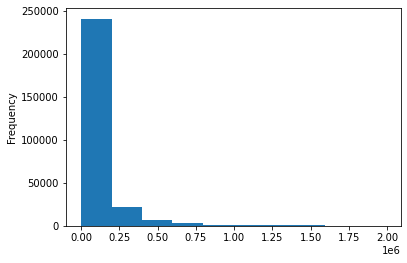

In [131]:
df_train_rent[target].plot(kind='hist')

In [132]:
df_train_rent[target].max()

1990000.0

In [133]:
df_train_rent[target].quantile(.95)

384126.504773764

In [134]:
df_train_rent[target].median()

60172.78617710584

In [135]:
df_train_rent[target].min()

389.6103896103896

### 1. Обучаем модель на объявлениях

In [136]:
to_drop = [target, 'id', 'date', 'floor']

In [137]:
X = df_train_rent.drop(columns=to_drop)
y = df_train_rent[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [138]:
X_train.head()

,city,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_name,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,osm_hotels_points_in_0.01,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,realty_type,price_type,avg_salary_12_2020,cnt_active_company,population,2_quarter_2019_flat_price,3_quarter_2019_flat_price,4_quarter_2019_flat_price,1_quarter_2020_flat_price,salary_per_life_min,min_month_food_price,price_building_materials_12_19,price_building_materials_01_20,price_building_materials_02_20,price_building_materials_03_20,floor_cor
178256,Москва,55.886710,37.659416,15,77,100,127,0,2,2,3,2,10,10,11,5.293286,Мытищи,187119.0,0.040087,2,49,76,97,0,0,0,0,2,6,7,9,1,3,4,0,0,0,0,0,0,7,15,23,0,3,4,5,11,57,69,83,0.136538,3.049315,0,0,0,0.117154,58,65,75,125,38,4433.0,1419.0,13.620968,14.421053,1983.928000,1985.842105,Москва,340.0,S28704,10,0,113988.044078,773098.0,12615279.0,195087.57,198230.93,203189.99,214278.63,543.3,4985.73,24071.31,26074.29,26909.85,28079.74,1
145463,Пушкино,56.015410,37.850315,3,29,71,106,0,0,0,0,0,2,10,11,0.610707,Пушкино,108253.0,0.254213,0,7,17,31,0,0,1,1,0,2,4,8,1,1,3,0,3,3,0,0,1,3,7,8,0,1,3,6,3,20,43,69,23.145459,0.636940,0,0,1,0.617874,0,7,15,115,30,2746.0,903.0,7.097345,8.892857,1974.654867,1979.321429,Московская область,68.0,S1370,10,0,63911.998366,175481.0,7599647.0,85403.58,88683.23,88486.09,88422.63,436.1,4274.15,74054.98,24762.03,20819.75,13254.94,-1
167127,Новосибирск,55.023926,82.948280,0,4,18,42,0,0,0,0,0,0,1,1,1.653427,Новосибирск,1625600.0,0.156835,0,1,2,23,0,0,0,1,0,0,1,2,0,4,4,0,0,2,0,1,1,1,1,4,0,1,1,2,0,1,8,25,0.803057,1.688548,0,0,0,0.820306,0,0,10,74,15,2165.0,517.0,9.579710,16.750000,1974.142857,2003.692308,Новосибирская область,172.0,S13409,10,0,43693.250108,101154.0,2793384.0,55836.25,56312.96,58709.50,55764.86,360.2,4195.02,0.00,124523.24,96488.59,0.00,0
255015,Краснодар,45.066704,38.925114,3,4,13,29,0,7,16,22,0,0,3,5,5.341228,Краснодар,1405000.0,0.339552,0,2,20,29,0,1,1,2,0,0,2,3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,3,3,8,19,339.700604,7.553531,0,0,0,0.091138,8,18,25,112,59,1647.0,667.0,4.438776,3.627451,1970.320388,1965.592593,Краснодарский край,80.0,S24059,110,0,40807.450388,11256.0,5648235.0,48318.72,51935.13,52551.61,51820.01,336.5,4224.72,39994.10,41046.57,38598.94,0.00,1
185642,Москва,55.836403,37.428730,1,3,9,

In [139]:
model = CatBoostRegressor(n_estimators=1000, depth=7)

In [140]:
cat_features = ['region', 'city', 'realty_type', 'osm_city_nearest_name', 'street']
model.fit(X=X_train, y=y_train, cat_features=cat_features, verbose=200)

Learning rate set to 0.101961


KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)

### 2. Обучаем прогноз на ручных оценках

In [ ]:
cities = pd.read_csv('../real-estate/data/df_test_v5.csv', compression='zip', usecols=['city'])['city'].unique().tolist()

In [ ]:
df_train_bank = df_train_bank[df_train_bank['city'].isin(cities)]

In [ ]:
X = df_train_bank.drop(columns=to_drop)
y = df_train_bank[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

In [ ]:
features = X_train.columns

In [ ]:
modelb = CatBoostRegressor(n_estimators=1000, depth=7)

In [ ]:
cat_features = ['region', 'city', 'realty_type', 'osm_city_nearest_name', 'street']
modelb.fit(X=X_train, y=y_train, cat_features=cat_features, verbose=200)

In [ ]:
y_pred = modelb.predict(X_test)
mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)

### 3. Калибровка модели объявлений

In [ ]:
h_pred = model.predict(df_train_bank.drop(to_drop, axis=1))

In [ ]:
df_train_bank['predicted_price'] = h_pred

In [ ]:
df_train_bank['delta_price'] = (df_train_bank['predicted_price'] - df_train_bank[target]) / df_train_bank[target]

In [ ]:
df_train_bank['delta_price'].mean()

##### Отклонения в зависимости от типа недвижимости

In [ ]:
df_train_bank['realty_type'].unique()

In [ ]:
df_train_bank[df_train_bank['realty_type'] == 10]['delta_price'].mean()

In [ ]:
df_train_bank[df_train_bank['realty_type'] == 100]['delta_price'].mean()

In [ ]:
df_train_bank[df_train_bank['realty_type'] == 110]['delta_price'].mean()

In [ ]:
df_train_bank['city'].nunique()

In [ ]:
df_train_bank['city'].value_counts()[:30]

In [ ]:
cities = df_train_bank['city'].value_counts()[:30]
df_train_bank[df_train_bank['city'].isin(cities.keys())].groupby('city')['delta_price'].mean()

In [ ]:
corr_dict = {}

for city, count in df_train_bank['city'].value_counts()[:30].items():
    price_real = df_train_bank[df_train_bank['city'] == city][target].values.mean()
    price_predicted = df_train_bank[df_train_bank['city'] == city]['predicted_price'].values.mean()
    price_delta = (price_predicted - price_real) / price_real
#     print(city, count, price_real, price_predicted, price_delta)
    corr_dict[city] = price_delta

In [ ]:
corr_dict

In [ ]:
realty_corr_dict = {}

realty_corr_dict[10] = df_train_bank[df_train_bank['realty_type'] == 10]['delta_price'].mean()
realty_corr_dict[100] = df_train_bank[df_train_bank['realty_type'] == 100]['delta_price'].mean()
realty_corr_dict[110] = df_train_bank[df_train_bank['realty_type'] == 110]['delta_price'].mean()

In [ ]:
realty_corr_dict

### 4. Делаем прогноз на ручных оценках

In [ ]:
df_out = pd.read_csv('../real-estate/data/df_test_v5.csv', compression='zip')

In [ ]:
df_out = df_out.drop(columns='Unnamed: 0')

In [ ]:
df_out['floor_cor'] = df_out['floor'].fillna(0).apply(clear_floor).astype(int)

df_out['street'] = df_out['street'].fillna('Unknown')
df_out['region'] = df_out['region'].fillna('Unknown')
df_out['city'] = df_out['city'].fillna('Unknown')
df_out['realty_type'] = df_out['realty_type'].fillna('Unknown')
df_out['osm_city_nearest_name'] = df_out['osm_city_nearest_name'].fillna('Unknown')

In [ ]:
df_out.head()

In [ ]:
def correct_prices(price, city, price_dict):
    if city in price_dict:
        return (1 - price_dict.get(city)) * price
    else:
        return price

In [ ]:
def correct_prices_rtypes(price, rtype, price_dict):
    if rtype in price_dict:
        return (1 - price_dict.get(rtype)) * price
    else:
        return price

In [ ]:
to_drop_2 = ['id', 'date', 'floor']

In [ ]:
df_out.columns[15]

In [ ]:
X_out = df_out.drop(columns=to_drop_2)[features]

In [ ]:
df_out['predicted_rent'] = model.predict(X_out)

In [ ]:
df_out['predicted_bank'] = modelb.predict(X_out)

In [ ]:
df_out['predicted_rent_corr'] = df_out.apply(lambda x: correct_prices(price=x['predicted_rent'], 
                                                                      city=x['city'], 
                                                                      price_dict=corr_dict), axis=1)

In [ ]:
df_out['predicted_rent_corr_type'] = df_out.apply(lambda x: correct_prices_rtypes(price=x['predicted_rent'], 
                                                                           rtype=x['realty_type'], 
                                                                           price_dict=realty_corr_dict), axis=1)

In [ ]:
df_out[target] = df_out[['predicted_rent_corr_type', 'predicted_bank']].mean(axis=1)
# df_out[target] = df_out[['predicted_rent_corr', 'predicted_bank']].mean(axis=1)
# df_out[target] = df_out[['predicted_rent', 'predicted_bank']].mean(axis=1)

In [ ]:
df_out[['id', 'predicted_rent', 'predicted_bank', 'predicted_rent_corr', 'predicted_rent_corr_type', target]].head()

In [ ]:
df_out.shape[0]

In [ ]:
df_out[target] = df_out[target].apply(lambda x: 0.9 * x if x >= 200000 else x)

In [ ]:
df_out[['id', target]].to_csv('out_v6_rtype2.csv', index=False)

In [ ]:
# df_out[['id', 'predicted_bank']].to_csv('out_v6_bank.csv', index=False)